# MODFLOW API Paper

# Create Trimesh Grid for McDonald Valley Problem for the "Optimization of groundwater withdrawals" example

This notebook can be used to create the MODFLOW 6 datasets used by the "Optimization of groundwater withdrawals" example, as reported in the MODFLOW 6 API paper (in progress). This notebook should be run prior to running the `optimize_mv_api.ipynb` notebook.

## Prerequisites
To run the simulation and process the results, the following publicly available software and data are required:

* __libmf6.dll__ (Windows) or __libmf6.so__ (linux or MacOS) pre-compiled dynamic-link library (dll)/shared object (so) and available from https://github.com/MODFLOW-USGS/executables. The operating specific pre-compiled dll/so should be installed in the `bin` subdirectory at the same level as the subdirectory containing this Jupyter Notebook (`../bin/`). 
* __mf6.exe__ (Windows) or __mf6__ (linux or MacOS) pre-compiled application and available from https://github.com/MODFLOW-USGS/executables. The operating specific pre-compiled application should be installed in the `bin` subdirectory at the same level as the subdirectory containing this Jupyter Notebook (`../bin/`). 
https://github.com/Deltares/xmipy.
* __flopy__ is a python package that can be used to build, run, and post-process MODFLOW 6 models. The source is available at https://github.com/modflowpy/flopy and the package can be installed from PyPI using `pip install flopy` or conda using `conda install flopy`.
    
## Building the McDonald Valley MODFLOW 6 datasets

We start by importing the necessary packages:

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

import flopy
import flopy.plot.styles as styles

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
numpy version: 1.21.6
flopy version: 3.3.6


## Load the model

In [2]:
ws = "./temp/mvmodel"
sim = flopy.mf6.MFSimulation.load(sim_ws=ws)
gwf = sim.get_model()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package evt...
    loading package wel...
    loading package drn...
    loading package sfr...
    loading package lak...
    loading package oc...
  loading ims package mv...


## Post-Process the Results

In [3]:
head = gwf.output.head().get_data()[:, 0, :]
spdis = gwf.output.budget().get_data(text='DATA-SPDIS')[0]
head.shape

(5, 20400)

In [4]:
bobj = gwf.output.budget()
bobj.list_unique_records()
drn_flow = bobj.get_data(text="DRN", full3D=True)[0]


RECORD           IMETH
----------------------
FLOW-JA-FACE         1
DATA-SPDIS           6
WEL                  6
DRN                  6
RCHA                 6
EVTA                 6
SFR                  6
LAK                  6


In [5]:
lake_cells = gwf.lak.connectiondata.array["cellid"]

In [6]:
gwf.lak.output.methods()

['zonebudget()',
 'budget()',
 'budgetcsv()',
 'package_convergence()',
 'obs()',
 'stage()']

In [7]:
lake_stage = gwf.lak.output.stage().get_data().flatten()[0]
lake_stage

10.528788056567812

In [8]:
# idx = np.where((cells['ibound'] == ilak) & (cells["elev"] <= lake_stage))
h0 = head[0, :].copy()
for k, i in lake_cells:
    h0[i] = lake_stage
head[0, :] = h0[:]

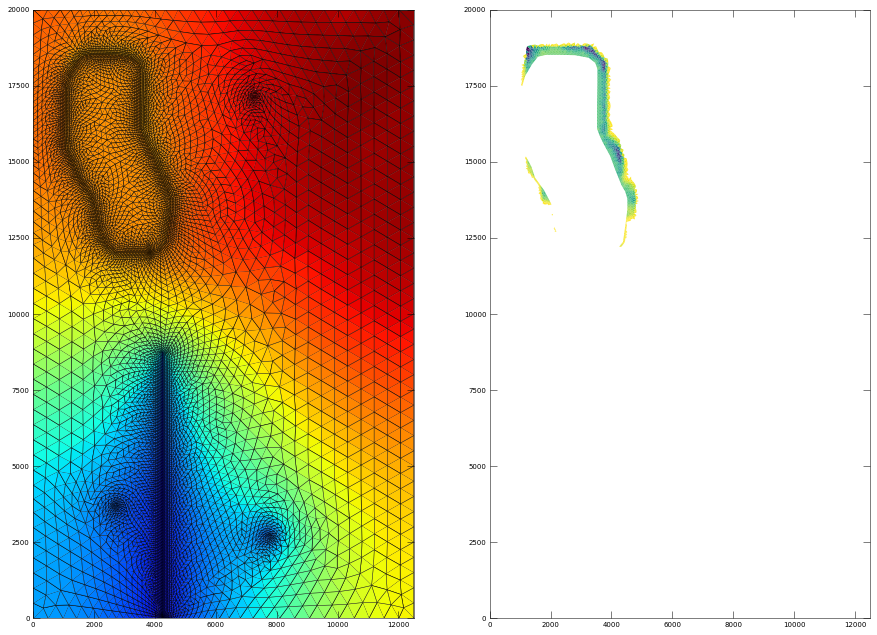

In [9]:
ilay = 0

with styles.USGSMap():
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(1, 2, 1, aspect='equal')
    pmv = flopy.plot.PlotMapView(gwf, ax=ax, layer=ilay)
    pmv.plot_array(head, cmap='jet', ec='black', lw=0.5)

    ax = fig.add_subplot(1, 2, 2, aspect='equal')
    pmv = flopy.plot.PlotMapView(gwf, ax=ax, layer=ilay)
    pmv.plot_array(drn_flow, masked_values=[0])
    # pmv.contour_array(head, levels=np.arange(20), cmap="jet")
    # pmv.plot_vector(spdis["qx"], spdis["qy"])

# Figure for Paper

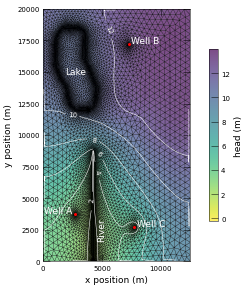

In [10]:
figwidth = 85 # mm
figwidth = figwidth / 10 / 2.54 # inches

figheight = 100 # mm
figheight = figheight / 10 / 2.54 # inches

ilay = 0

with styles.USGSMap():

    fig = plt.figure(
        figsize=(figwidth, figheight),
        constrained_layout=True,
    )
    ax = fig.add_subplot(1, 1, 1)
    # ax.set_aspect('equal')
    pmv = flopy.plot.PlotMapView(gwf, ax=ax, layer=ilay)

    pa = pmv.plot_array(head, cmap='viridis_r', ec='none', alpha=0.7)
    pmv.plot_grid(linewidths=0.2, colors='black')
    ca = pmv.contour_array(head, levels=(2, 4, 6, 8, 10, 12), colors="white", linewidths=0.5)
    ax.clabel(ca, inline=1, fmt='%2.0f')
    

    pmv.plot_bc("SFR", color='cyan')

    wellnames = ['A', 'B', 'C']
    cellids = gwf.wel.stress_period_data.array[0]["cellid"]
    for idx, cellid in enumerate(cellids):
        x, y = gwf.modelgrid.xcellcenters[cellid[1]], gwf.modelgrid.ycellcenters[cellid[1]] 
        ax.plot(x, y, 'ro', markersize=2)
        s = f"Well {wellnames[idx]}"
        if idx == 0:
            xx = x - 250
            ha = "right"
        else:
            xx = x + 250
            ha = "left"
        styles.add_text(
            ax, 
            text=s, 
            x=xx, 
            y=y+250, 
            color='white', 
            transform=False, 
            bold=False, 
            italic=False,
            va="center", 
            ha=ha,
        )    

    styles.add_text(
        ax, 
        text="Lake", 
        x=2750, 
        y=15000, 
        color='white', 
        transform=False, 
        bold=False, 
        italic=False,
        va="center", 
        ha="center",
    )
    styles.add_text(
        ax, 
        text="River", 
        x=5000, 
        y=2500, 
        color='white', 
        transform=False, 
        bold=False, 
        italic=False,
        va="center", 
        ha="center",
        rotation="vertical",
    )

    ax.set_xlabel('x position (m)')
    ax.set_ylabel('y position (m)')
    cbar = fig.colorbar(pa, shrink=0.68)
    cbar.ax.set_ylabel('head (m)')

    fname = os.path.join("figures", "mf6_disv.png")
    plt.savefig(fname, dpi=600)